In [3]:
import time
from collections import deque
import os
import habitat
import math
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import skimage
import skfmm
import gym
import logging
from torchvision import transforms
from PIL import Image
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.datasets.pointnav.pointnav_dataset import PointNavDatasetV1
import sys
if sys.platform == 'darwin':
    matplotlib.use("tkagg")
import matplotlib.pyplot as plt
import random
from typing import Type, Union
from habitat import Config, Env, RLEnv, make_dataset
from habitat_baselines.common.environments import get_env_class
from matplotlib.patches import Circle
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
from arguments import get_args,multiple_config,init_config
from utils import draw_top_down_map
from env import Env as MyEnv
import pose as pu

In [5]:
argumnts = ''
args = get_args(argumnts)
args.num_processes = 8

np.random.seed(args.seed)
torch.manual_seed(args.seed)

if args.cuda:
    torch.cuda.manual_seed(args.seed)
args_list, env_configs = multiple_config(args)
config = env_configs[0]
config.defrost()
W = 256#640
H = 256#360
#config.SIMULATOR.RGB_SENSOR.HEIGHT = H
#config.SIMULATOR.RGB_SENSOR.WIDTH = W
#config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
#config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.SIMULATOR.TURN_ANGLE = 1
config.SIMULATOR.TILT_ANGLE = 1
config.SIMULATOR.FORWARD_STEP_SIZE = 0.1#0.05
config.freeze()

Auto GPU config:
Number of processes: 9
Number of processes on GPU 0: 9
Number of processes per GPU: 0


In [6]:
env = MyEnv(config=config)

2020-05-24 22:01:04,534 Initializing dataset PointNav-v1


KeyboardInterrupt: 

In [10]:
res = transforms.Compose([transforms.ToPILImage(),
                    transforms.Resize((256, 256),interpolation = Image.NEAREST)])

# Test path follower

In [23]:
obs,info, done = env.reset()

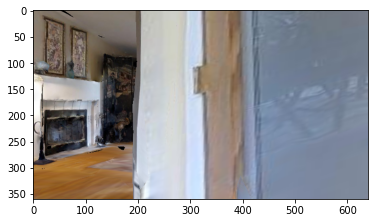

In [27]:
plt.imshow(obs['rgb'])

In [33]:
ti = time.time()
for i in range(1):
    obs,info,done = env.step(2,ideal_action=True)
    if done:
        print('DONE')
        break
me = time.time()
print(i,'\t',me-ti)
print(obs['pos'],'\t',obs['pointgoal_with_gps_compass'])

0 	 0.07555961608886719
[-0.567014137497674, -3.1747718354908976] 	 [3.2207043  0.16656409]


In [ ]:
observations['rgb'] = np.copy(res(observations['rgb']))
mmax = np.copy(observations['depth']).max()
shape = observations['depth'].shape
im = np.uint8(minmax_scale(observations['depth'].ravel(), feature_range=(0,255)).reshape(shape)[:,:,0])
im = np.expand_dims(res(im),axis=2)
im = minmax_scale(im.ravel(), feature_range=(0,mmax)).reshape([256,256,1])
observations['depth'] = im

In [8]:
print([env.goalx,env.goaly],[env.trux,env.truy])

[-3.9402378, -2.0596905] [-0.004697770595086581, -0.056159525656312326]


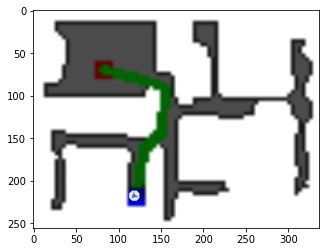

In [9]:
top_down_map = draw_top_down_map(info, obs["heading"][0], obs['rgb'][0].shape[0])
plt.imshow(top_down_map)

In [10]:
print(obs['gps'])
print(env.trux,env.truy,env.truz)
print(env.goalx,env.goaly)
print(env.dx_gt, env.dy_gt, env.do_gt)

[-0.00469777  0.05615953]
-0.004697770595086581 -0.056159525656312326 0
-3.9402378 -2.0596905
0.004059703100355026 -0.01901207985494872 -0.0318408268720034


# Test ORBLAM2 localization

In [7]:
from habitat_baselines.config.default import get_config as cfg_baseline
from habitat_baselines.slambased.mappers import DirectDepthMapper
from habitat_baselines.slambased.reprojection import (
    angle_to_pi_2_minus_pi_2 as norm_ang)
import orbslam2
from habitat_baselines.slambased.reprojection import (
    homogenize_p,
    project_tps_into_worldmap)

In [8]:
agent_config = cfg_baseline()
agent_config.defrost()
config.defrost()
config.ORBSLAM2 = agent_config.ORBSLAM2
config.SLAM_VOCAB_PATH = '/root/3rdparty/ORB_SLAM2/Vocabulary/ORBvoc.txt'
config.SLAM_SETTINGS_PATH = '/habitat-api/habitat_baselines/slambased/data/mp3d3_small1k.yaml'
config.ORBSLAM2.CAMERA_HEIGHT = config.SIMULATOR.DEPTH_SENSOR.POSITION[1]
config.ORBSLAM2.H_OBSTACLE_MIN = (0.3 * config.ORBSLAM2.CAMERA_HEIGHT)
config.ORBSLAM2.H_OBSTACLE_MAX = (1.0 * config.ORBSLAM2.CAMERA_HEIGHT)
config.ORBSLAM2.MIN_PTS_IN_OBSTACLE = (config.SIMULATOR.DEPTH_SENSOR.WIDTH / 2.0)
agent_config.freeze()
config.freeze()
device=torch.device("cuda:0")

In [9]:
mapper = DirectDepthMapper(
            camera_height=config.ORBSLAM2.CAMERA_HEIGHT,
            near_th=config.ORBSLAM2.D_OBSTACLE_MIN,
            far_th=config.ORBSLAM2.D_OBSTACLE_MAX,
            h_min=config.ORBSLAM2.H_OBSTACLE_MIN,
            h_max=config.ORBSLAM2.H_OBSTACLE_MAX,
            map_size=config.ORBSLAM2.MAP_SIZE,
            map_cell_size=config.ORBSLAM2.MAP_CELL_SIZE,
            device=device,
        )
slam = orbslam2.System(config.SLAM_VOCAB_PATH, config.SLAM_SETTINGS_PATH, orbslam2.Sensor.RGBD)

In [10]:
slam.set_use_viewer(False)
slam.initialize()

True

In [17]:
obs,info, done = env.reset()
slam.reset()
map2DObstacles = torch.zeros(1, 1, int(config.ORBSLAM2.MAP_SIZE/config.ORBSLAM2.MAP_CELL_SIZE), int(config.ORBSLAM2.MAP_SIZE/config.ORBSLAM2.MAP_CELL_SIZE)).float().to(device)
cur_time = 0
tru_cords = []
orb_cords = []

In [22]:
for step in range(100):
    cur_time += 0.1
    obs,info,done = env.step(2,ideal_action=True)
    if done:
        print('DONE')
        break
    slam.process_image_rgbd(obs['rgb'], obs['depth'], cur_time)
    track = slam.get_tracking_state()
    pose6D = homogenize_p(torch.from_numpy(np.array(slam.get_trajectory_points())[-1])[1:].view(3, 4).to(device)).view(1, 4, 4)
    current_obstacles = mapper(torch.from_numpy(obs['depth']).to(device).squeeze(), pose6D).to(device)
    map2DObstacles = torch.max(map2DObstacles, current_obstacles.unsqueeze(0).unsqueeze(0))
    get_position_on_map = project_tps_into_worldmap(
            pose6D.view(1, 4, 4),
            config.ORBSLAM2.MAP_CELL_SIZE,
            config.ORBSLAM2.MAP_SIZE,
            True)
    get_orientation_on_map = torch.tensor(
            [[pose6D.view(1, 4, 4)[0, 0, 0], pose6D.view(1, 4, 4)[0, 0, 2]],
             [pose6D.view(1, 4, 4)[0, 2, 0], pose6D.view(1, 4, 4)[0, 2, 2]]])
    tps = pose6D.view(1, 4, 4)
    topdown_p = torch.tensor([[1.0, 0, 0, 0], [0, 0, 1.0, 0]]).to(device)
    world_coords = torch.bmm(
            topdown_p.view(1, 2, 4).expand(tps.size(0), 2, 4),
            tps[:, :, 3:].view(-1, 4, 1))[0]
    tru_cords.append([env.trux,env.truy])
    orb_cords.append(world_coords.cpu().flatten().numpy()[::-1]*10*[1,-1])
print(world_coords.cpu().flatten().numpy()[::-1]*10*[1,-1],'\t',[env.trux,env.truy])

AssertionError: Episode over, call reset before calling step

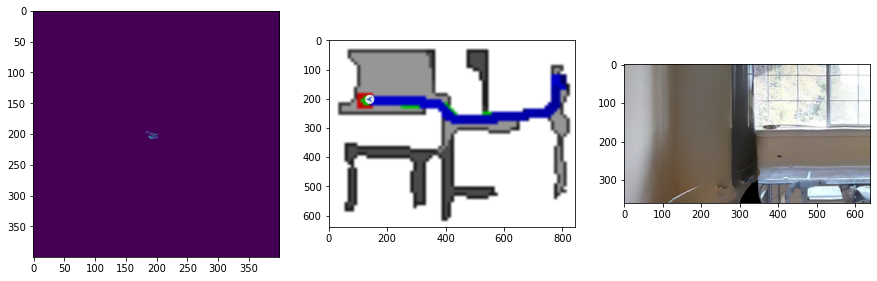

In [23]:
top_down_map = draw_top_down_map(info, obs["heading"][0], obs['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax.imshow(map2DObstacles[0][0].cpu())
ax2.imshow(top_down_map)
ax3.imshow(obs['rgb'])

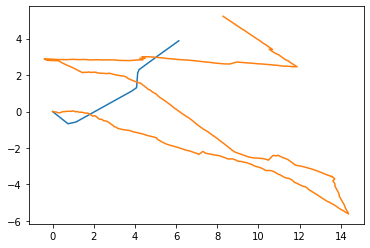

In [24]:
x = np.array(tru_cords)[:,0].T
y = np.array(tru_cords)[:,1].T
x1 = np.array(orb_cords)[:,0].T
y1 = np.array(orb_cords)[:,1].T
plt.plot(y, x)
plt.plot(y1, x1)

# DDPPO Test

In [20]:
from resnet_policy import PointNavResNetPolicy
from habitat_baselines.common.utils import batch_obs, linear_decay
from gym.spaces.box import Box
from habitat_baselines.config.default import get_config as cfg_baseline
from habitat_baselines.slambased.mappers import DirectDepthMapper
from habitat_baselines.slambased.reprojection import angle_to_pi_2_minus_pi_2 as norm_ang
import orbslam2
from habitat_baselines.slambased.reprojection import (
    homogenize_p,
    project_tps_into_worldmap)
import copy

In [140]:
try:
    env.close()
except NameError:
    pass
finally:
    env = MyEnv(config=config)
agent_config = cfg_baseline()
agent_config.defrost()
config.defrost()
config.ORBSLAM2 = agent_config.ORBSLAM2
config.SLAM_VOCAB_PATH = '/root/3rdparty/ORB_SLAM2/Vocabulary/ORBvoc.txt'
config.SLAM_SETTINGS_PATH = '/habitat-api/habitat_baselines/slambased/data/mp3d3_small1k.yaml'
config.ORBSLAM2.CAMERA_HEIGHT = config.SIMULATOR.DEPTH_SENSOR.POSITION[1]
config.ORBSLAM2.H_OBSTACLE_MIN = (0.3 * config.ORBSLAM2.CAMERA_HEIGHT)
config.ORBSLAM2.H_OBSTACLE_MAX = (1.0 * config.ORBSLAM2.CAMERA_HEIGHT)
config.ORBSLAM2.MIN_PTS_IN_OBSTACLE = (config.SIMULATOR.DEPTH_SENSOR.WIDTH / 2.0)
agent_config.freeze()
config.freeze()
device=torch.device("cuda:0")

2020-05-19 12:29:16,750 Initializing dataset PointNav-v1
2020-05-19 12:29:27,047 initializing sim Sim-v0
2020-05-19 12:29:31,236 Initializing task Nav-v0


In [141]:
obs_space = copy.deepcopy(env.observation_space)
obs_space.spaces['pos'] = Box(low=-1000, high=1000, shape=(2,), dtype=np.float32)
obs_space.spaces['rgb'] = Box(low=-1000, high=1000, shape=(256,256,3), dtype=np.float32)
obs_space.spaces['depth'] = Box(low=-1000, high=1000, shape=(256,256,1), dtype=np.float32)
del obs_space.spaces['gps']
del obs_space.spaces['compass']
del obs_space.spaces['heading']
del obs_space.spaces['pointgoal']
del obs_space.spaces['pointgoal_with_gps_compass']

In [142]:
actor_critic = PointNavResNetPolicy(
            observation_space=obs_space,
            action_space=env.action_space,
            hidden_size=512,
            rnn_type='LSTM',
            num_recurrent_layers=2,
            backbone='resnet50',
            goal_sensor_uuid='pos',
            normalize_visual_inputs=False).to(device)
mapper = DirectDepthMapper(
            camera_height=config.ORBSLAM2.CAMERA_HEIGHT,
            near_th=config.ORBSLAM2.D_OBSTACLE_MIN,
            far_th=config.ORBSLAM2.D_OBSTACLE_MAX,
            h_min=config.ORBSLAM2.H_OBSTACLE_MIN,
            h_max=config.ORBSLAM2.H_OBSTACLE_MAX,
            map_size=config.ORBSLAM2.MAP_SIZE,
            map_cell_size=config.ORBSLAM2.MAP_CELL_SIZE,
            device=device,
        )
slam = orbslam2.System(config.SLAM_VOCAB_PATH, config.SLAM_SETTINGS_PATH, orbslam2.Sensor.RGBD)
slam.set_use_viewer(False)
slam.initialize()

True

In [143]:
pretrained_state = torch.load('ckpt.906.pth', map_location="cpu")
actor_critic.load_state_dict({k[len("actor_critic.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic" in k})

<All keys matched successfully>

In [144]:
from torchvision import transforms
from PIL import Image
res = transforms.Compose([transforms.ToPILImage(),
                    transforms.Resize((256, 256),
                                      interpolation = Image.NEAREST)])

In [204]:
obs,info, done = env.reset()
slam.reset()
map2DObstacles = torch.zeros(1, 1, int(config.ORBSLAM2.MAP_SIZE/config.ORBSLAM2.MAP_CELL_SIZE), int(config.ORBSLAM2.MAP_SIZE/config.ORBSLAM2.MAP_CELL_SIZE)).float().to(device)
cur_time = 0
tru_cords = []
orb_cords = []
obs_256 = obs.copy()
obs_256['rgb'] = np.array(res(obs_256['rgb']))
obs_256['depth'] = np.expand_dims(np.array(res(obs_256['depth'])),axis=2)
batch = batch_obs([obs_256],device)
test_recurrent_hidden_states = torch.zeros(
            4,
            1,
            512,
            device=device)
prev_actions = torch.zeros(1, 1, device=device, dtype=torch.long)
not_done_masks = torch.zeros(1, 1, device=device)

1
1
2
0
DONE
DONE


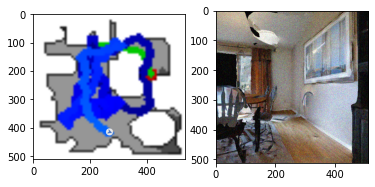

In [228]:
for step in range(10):
    ( _,actions, _,test_recurrent_hidden_states) = actor_critic.act(
                        batch,
                        test_recurrent_hidden_states,
                        prev_actions,
                        not_done_masks,
                        deterministic=False)
    prev_actions.copy_(actions)
    not_done_masks = torch.tensor(
                    [[0.0] if done else [1.0]],
                    dtype=torch.float,
                    device=device)
    act = int(actions[0][0].cpu().numpy())
    print(act)
    for i in range(5):
        obs,info,done = env.step(act,ideal_action=False)
        slam.process_image_rgbd(obs['rgb'], obs['depth'], cur_time)
        track = slam.get_tracking_state()
        pose6D = homogenize_p(torch.from_numpy(np.array(slam.get_trajectory_points())[-1])[1:].view(3, 4).to(device)).view(1, 4, 4)
        current_obstacles = mapper(torch.from_numpy(obs['depth']).to(device).squeeze(), pose6D).to(device)
        map2DObstacles = torch.max(map2DObstacles, current_obstacles.unsqueeze(0).unsqueeze(0))
        tps = pose6D.view(1, 4, 4)
        topdown_p = torch.tensor([[1.0, 0, 0, 0], [0, 0, 1.0, 0]]).to(device)
        world_coords = torch.bmm(
                topdown_p.view(1, 2, 4).expand(tps.size(0), 2, 4),
                tps[:, :, 3:].view(-1, 4, 1))[0]
        tru_cords.append([env.trux,env.truy])
        orb_pos = world_coords.cpu().flatten().numpy()[::-1]*10*[1,-1]
        orb_cords.append(orb_pos)
        
        if done==True:
            print('DONE')
            break

    top_down_map = draw_top_down_map(info, obs["heading"][0], obs['rgb'][0].shape[0])
    obs['pos'] = np.copy(orb_pos)#obs['pointgoal_with_gps_compass'][::-1])
    obs_256 = obs.copy()
    obs_256['rgb'] = np.array(res(obs_256['rgb']))
    obs_256['depth'] = np.expand_dims(np.array(res(obs_256['depth'])),axis=2)
    batch = batch_obs([obs_256],device)
    if done==True:
        print('DONE')
        break
            
plt.subplot(1,2,1)
plt.imshow(top_down_map)
plt.subplot(1,2,2)
plt.imshow(obs['rgb'])

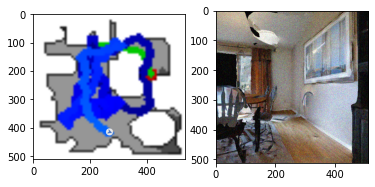

In [229]:
plt.subplot(1,2,1)
plt.imshow(top_down_map)
plt.subplot(1,2,2)
plt.imshow(obs['rgb'])

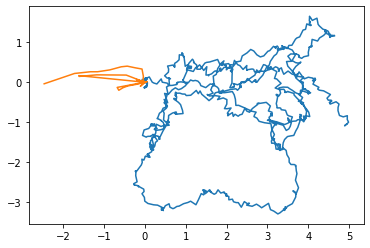

In [230]:
x = np.array(tru_cords)[:,0].T
y = np.array(tru_cords)[:,1].T
x1 = np.array(orb_cords)[:,0].T
y1 = np.array(orb_cords)[:,1].T
plt.plot(y, x)
plt.plot(y1, x1)